In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install category_encoders

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import category_encoders as ce

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import make_scorer, roc_curve, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("./dataset/Stockout/data.zip", compression="zip")
train, test = train_test_split(df, train_size=0.7, stratify=df['went_on_backorder'])
y_train = train.pop('went_on_backorder')
y_test = test.pop('went_on_backorder')

In [7]:
cat_cols = train.select_dtypes(include=['object']).columns.tolist()
# categorical imputer
for cat_col in cat_cols:
    train[cat_col].fillna("__MISS__", inplace=True)
    test[cat_col].fillna("__MISS__", inplace=True)
# ordinal encoder
oe = OrdinalEncoder()
train[cat_cols] = oe.fit_transform(train[cat_cols])
test[cat_cols] = oe.transform(test[cat_cols])
# label encoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
# numerical imputer
simple_imputer = SimpleImputer(strategy="median", copy=False)
train = simple_imputer.fit_transform(train)
test = simple_imputer.transform(test)

In [38]:
def plot_prob_dist(yhat_prob, y):
    plt.figure()
    preds = pd.DataFrame({"yhat_prob_test": yhat_prob[:,1], "y_test": y})
    sns.kdeplot(x=preds['yhat_prob_test'], hue=preds['y_test'])
    plt.title("Distibution of predicted probabilities")
    plt.xlabel("Predicted probabilities")
    plt.show()
    
def print_classification_report(clf, test, y_test):
    yhat_test = clf.predict(test)
    yhat_prob_test= clf.predict_proba(test)
    cm = confusion_matrix(y_test, yhat_test)
    print("********************************************************")
    print("Accuracy on Test data ", accuracy_score(y_test, yhat_test))
    print("********************************************************")
    print("Balanced Accuracy on Test data ", balanced_accuracy_score(y_test, yhat_test))
    print("********************************************************")
    print("AUC ROC on Test data ", roc_auc_score(y_test, yhat_test))
    print("********************************************************")
    print(classification_report(y_test, yhat_test))
    print("********************************************************")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    cm = confusion_matrix(y_test, yhat_test)
    ConfusionMatrixDisplay(cm).plot(ax=ax1)
    fpr, tpr, _ = roc_curve(y_test, yhat_test, pos_label=clf.classes_[1])
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax2)
    plot_prob_dist(yhat_prob_test, y_test)

### Decision tree performance wrt max depth

In [16]:
scoring = {'AUC': make_scorer(roc_auc_score), 'Accuracy': make_scorer(accuracy_score), 
           "F1 Score": make_scorer(f1_score), "BalancedAccuracy": make_scorer(balanced_accuracy_score)}

In [46]:
max_depths = [10, 20, 30, 40, 50, 70, 100]
params = {"max_depth": max_depths}
clf = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=1234, class_weight="balanced")
gs = GridSearchCV(clf, cv=5, n_jobs=-2, param_grid=params, scoring=scoring, return_train_score=True, refit="BalancedAccuracy")
gs.fit(train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=1234),
             n_jobs=-2, param_grid={'max_depth': [10, 20, 30, 40, 50, 70, 100]},
             refit='BalancedAccuracy', return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'Accuracy': make_scorer(accuracy_score),
                      'BalancedAccuracy': make_scorer(balanced_accuracy_score),
                      'F1 Score': make_scorer(f1_score)})

In [43]:
gs.best_estimator_.max_depth

10

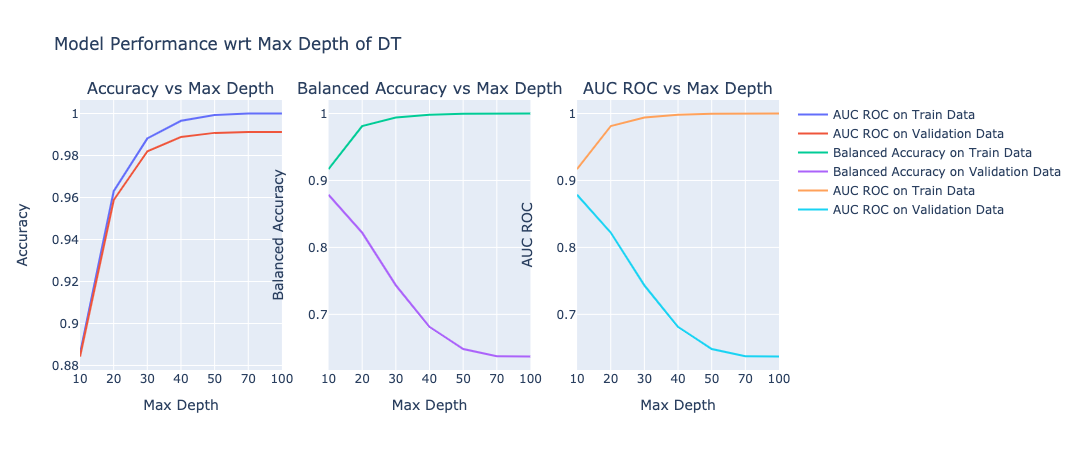

In [47]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("Accuracy vs Max Depth", "Balanced Accuracy vs Max Depth", "AUC ROC vs Max Depth"))
# accuracy
fig.add_trace(go.Scatter(x=max_depths, y=gs.cv_results_['mean_train_Accuracy'], mode='lines', name='AUC ROC on Train Data'),
             row=1, col=1)
fig.add_trace(go.Scatter(x=max_depths, y=gs.cv_results_['mean_test_Accuracy'], mode='lines', name='AUC ROC on Validation Data'),
             row=1, col=1)
# f1 score
fig.add_trace(go.Scatter(x=max_depths, y=gs.cv_results_['mean_train_BalancedAccuracy'], mode='lines', name='Balanced Accuracy on Train Data'), 
             row=1, col=2)
fig.add_trace(go.Scatter(x=max_depths, y=gs.cv_results_['mean_test_BalancedAccuracy'], mode='lines', name='Balanced Accuracy on Validation Data'),
             row=1, col=2)
# auc roc
fig.add_trace(go.Scatter(x=max_depths, y=gs.cv_results_['mean_train_AUC'], mode='lines', name='AUC ROC on Train Data'), 
             row=1, col=3)
fig.add_trace(go.Scatter(x=max_depths, y=gs.cv_results_['mean_test_AUC'], mode='lines', name='AUC ROC on Validation Data'),
             row=1, col=3)

# Update xaxis properties
fig.update_xaxes(title_text="Max Depth", row=1, col=1, type='category')
fig.update_xaxes(title_text="Max Depth", row=1, col=2, type='category')
fig.update_xaxes(title_text="Max Depth", row=1, col=3, type='category')
# Update yaxis properties
fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Balanced Accuracy", row=1, col=2)
fig.update_yaxes(title_text="AUC ROC",  row=1, col=3)
# update layout
fig.update_layout(title='Model Performance wrt Max Depth of DT')
fig.show()

********************************************************
Accuracy on Test data  0.8854881329020179
********************************************************
Balanced Accuracy on Test data  0.8807924400137563
********************************************************
AUC ROC on Test data  0.8807924400137563
********************************************************
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    502970
           1       0.05      0.88      0.09      3388

    accuracy                           0.89    506358
   macro avg       0.52      0.88      0.52    506358
weighted avg       0.99      0.89      0.93    506358

********************************************************


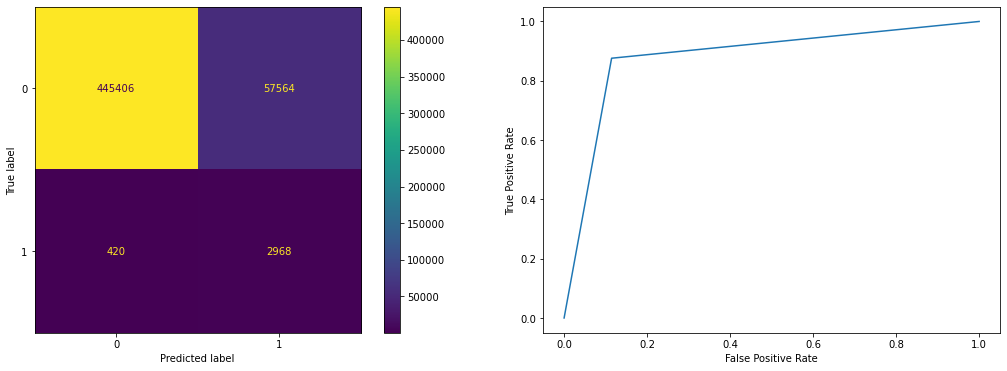

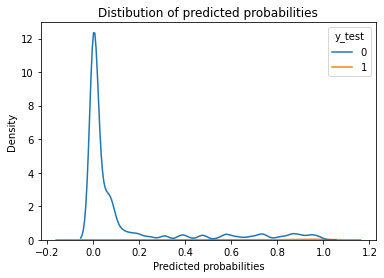

In [45]:
print_classification_report(gs.best_estimator_, test, y_test)

### Decision tree performance wrt pruning alpha

In [24]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

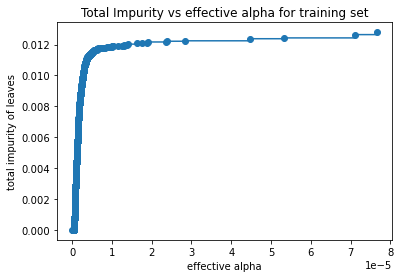

In [25]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [48]:
ccp_alphas = [0, 1e-6, 2e-6, 5e-6, 1e-5, 2e-5, 3e-5, 4e-5]
params = {"ccp_alpha": ccp_alphas}
clf = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=1234, class_weight="balanced")
gs = GridSearchCV(clf, cv=5, n_jobs=-2, param_grid=params, scoring=scoring, return_train_score=True, refit="BalancedAccuracy")
gs.fit(train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=1234),
             n_jobs=-2,
             param_grid={'ccp_alpha': [0, 1e-06, 2e-06, 5e-06, 1e-05, 2e-05,
                                       3e-05, 4e-05]},
             refit='BalancedAccuracy', return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'Accuracy': make_scorer(accuracy_score),
                      'BalancedAccuracy': make_scorer(balanced_accuracy_score),
                      'F1 Score': make_scorer(f1_score)})

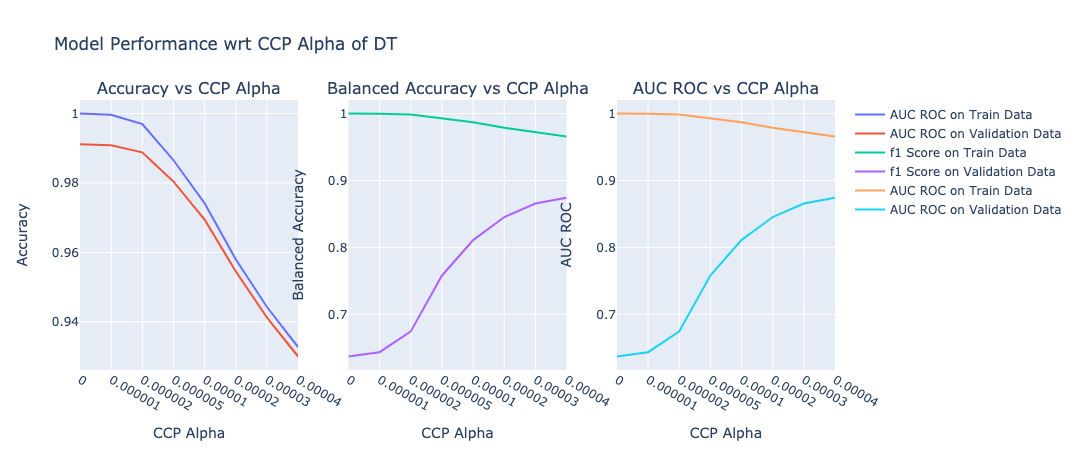

In [49]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("Accuracy vs CCP Alpha", "Balanced Accuracy vs CCP Alpha", "AUC ROC vs CCP Alpha"))
# accuracy
fig.add_trace(go.Scatter(x=ccp_alphas, y=gs.cv_results_['mean_train_Accuracy'], mode='lines', name='AUC ROC on Train Data'),
             row=1, col=1)
fig.add_trace(go.Scatter(x=ccp_alphas, y=gs.cv_results_['mean_test_Accuracy'], mode='lines', name='AUC ROC on Validation Data'),
             row=1, col=1)
# f1 score
fig.add_trace(go.Scatter(x=ccp_alphas, y=gs.cv_results_['mean_train_BalancedAccuracy'], mode='lines', name='f1 Score on Train Data'), 
             row=1, col=2)
fig.add_trace(go.Scatter(x=ccp_alphas, y=gs.cv_results_['mean_test_BalancedAccuracy'], mode='lines', name='f1 Score on Validation Data'),
             row=1, col=2)
# auc roc
fig.add_trace(go.Scatter(x=ccp_alphas, y=gs.cv_results_['mean_train_AUC'], mode='lines', name='AUC ROC on Train Data'), 
             row=1, col=3)
fig.add_trace(go.Scatter(x=ccp_alphas, y=gs.cv_results_['mean_test_AUC'], mode='lines', name='AUC ROC on Validation Data'),
             row=1, col=3)

# Update xaxis properties
fig.update_xaxes(title_text="CCP Alpha", row=1, col=1, type='category')
fig.update_xaxes(title_text="CCP Alpha", row=1, col=2, type='category')
fig.update_xaxes(title_text="CCP Alpha", row=1, col=3, type='category')
# Update yaxis properties
fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Balanced Accuracy", row=1, col=2)
fig.update_yaxes(title_text="AUC ROC",  row=1, col=3)
# update layout
fig.update_layout(title='Model Performance wrt CCP Alpha of DT')
fig.show()

********************************************************
Accuracy on Test data  0.8721260452091208
********************************************************
Balanced Accuracy on Test data  0.879490059859077
********************************************************
AUC ROC on Test data  0.8794900598590769
********************************************************
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    502970
           1       0.04      0.89      0.08      3388

    accuracy                           0.87    506358
   macro avg       0.52      0.88      0.51    506358
weighted avg       0.99      0.87      0.93    506358

********************************************************


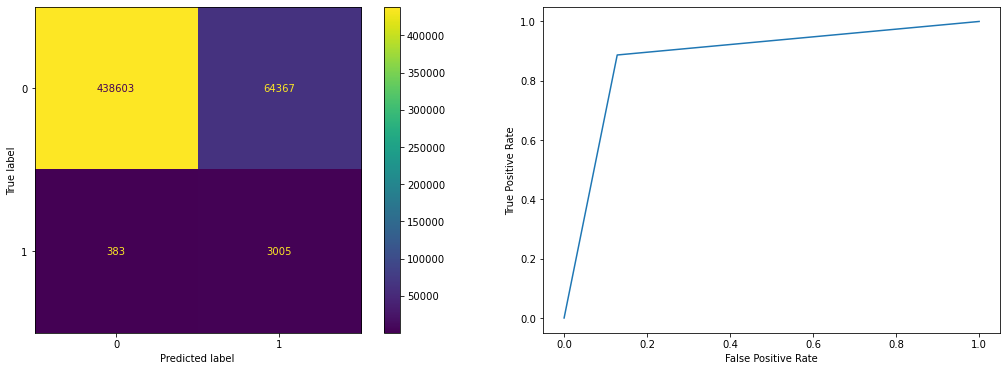

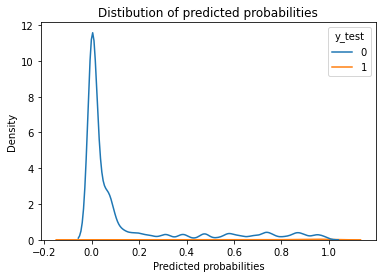

In [41]:
print_classification_report(gs.best_estimator_, test, y_test)

## Decision tree performance with min sample leaf

In [31]:
min_samples_split = [0.001, 0.005, 0.01, 0.05, 0.1]
params = {"min_samples_split": min_samples_split}
clf = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=1234, ccp_alpha=0, max_depth=10,
                             class_weight="balanced")
gs = GridSearchCV(clf, cv=5, n_jobs=-2, param_grid=params, scoring=scoring, return_train_score=True, refit="BalancedAccuracy")
gs.fit(train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(ccp_alpha=0,
                                              class_weight='balanced',
                                              max_depth=10, random_state=1234),
             n_jobs=-2,
             param_grid={'min_samples_split': [0.001, 0.005, 0.01, 0.05, 0.1]},
             refit='BalancedAccuracy', return_train_score=True,
             scoring={'AUC': make_scorer(roc_auc_score),
                      'Accuracy': make_scorer(accuracy_score),
                      'BalancedAccuracy': make_scorer(balanced_accuracy_score),
                      'F1 Score': make_scorer(f1_score)})

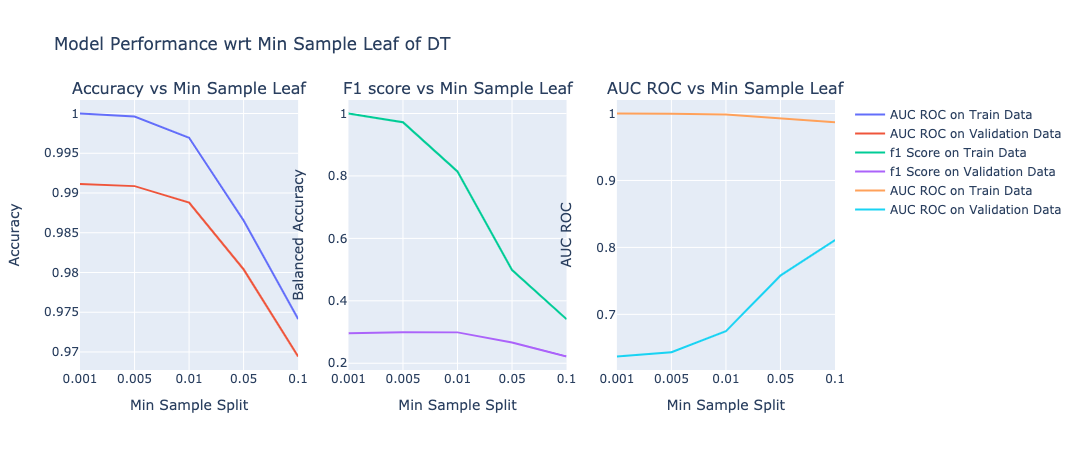

In [50]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("Accuracy vs Min Sample Leaf", "F1 score vs Min Sample Leaf", "AUC ROC vs Min Sample Leaf"))
# accuracy
fig.add_trace(go.Scatter(x=min_samples_split, y=gs.cv_results_['mean_train_Accuracy'], mode='lines', name='AUC ROC on Train Data'),
             row=1, col=1)
fig.add_trace(go.Scatter(x=min_samples_split, y=gs.cv_results_['mean_test_Accuracy'], mode='lines', name='AUC ROC on Validation Data'),
             row=1, col=1)
# f1 score
fig.add_trace(go.Scatter(x=min_samples_split, y=gs.cv_results_['mean_train_F1 Score'], mode='lines', name='f1 Score on Train Data'), 
             row=1, col=2)
fig.add_trace(go.Scatter(x=min_samples_split, y=gs.cv_results_['mean_test_F1 Score'], mode='lines', name='f1 Score on Validation Data'),
             row=1, col=2)
# auc roc
fig.add_trace(go.Scatter(x=min_samples_split, y=gs.cv_results_['mean_train_AUC'], mode='lines', name='AUC ROC on Train Data'), 
             row=1, col=3)
fig.add_trace(go.Scatter(x=min_samples_split, y=gs.cv_results_['mean_test_AUC'], mode='lines', name='AUC ROC on Validation Data'),
             row=1, col=3)

# Update xaxis properties
fig.update_xaxes(title_text="Min Sample Split", row=1, col=1, type='category')
fig.update_xaxes(title_text="Min Sample Split", row=1, col=2, type='category')
fig.update_xaxes(title_text="Min Sample Split", row=1, col=3, type='category')
# Update yaxis properties
fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Balanced Accuracy", row=1, col=2)
fig.update_yaxes(title_text="AUC ROC",  row=1, col=3)
# update layout
fig.update_layout(title='Model Performance wrt Min Sample Leaf of DT')
fig.show()

********************************************************
Accuracy on Test data  0.9228056039402952
********************************************************
Balanced Accuracy on Test data  0.8910748958741157
********************************************************
AUC ROC on Test data  0.8910748958741157
********************************************************
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    502970
           1       0.07      0.86      0.13      3388

    accuracy                           0.92    506358
   macro avg       0.53      0.89      0.54    506358
weighted avg       0.99      0.92      0.95    506358

********************************************************


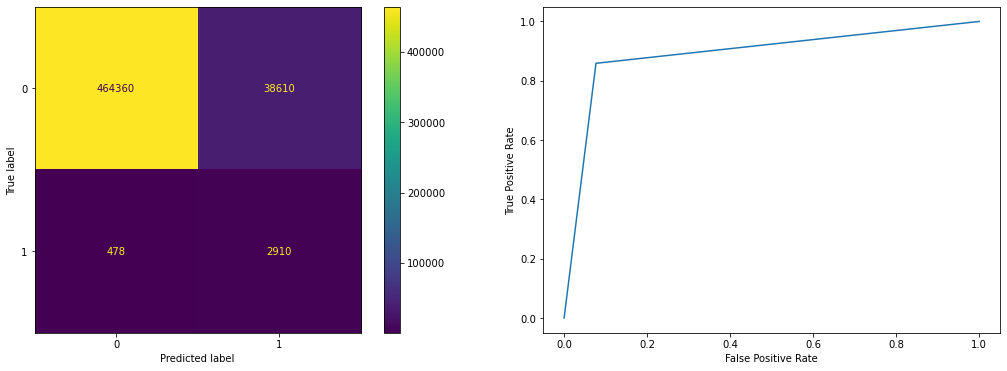

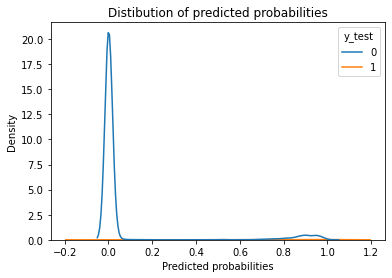

In [51]:
print_classification_report(gs.best_estimator_, test, y_test)

In [34]:
%%time
clf = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=1234, ccp_alpha=0.001, 
                             class_weight="balanced", min_samples_split=0.01)
clf.fit(train, y_train)

CPU times: user 14.4 s, sys: 87.3 ms, total: 14.5 s
Wall time: 14.5 s


DecisionTreeClassifier(ccp_alpha=0.001, class_weight='balanced',
                       min_samples_split=0.01, random_state=1234)

In [ ]:
clf.